In [1]:
import pandas as pd
pd.set_option('display.max_column',None)
import gc
import gensim
import numpy as np
from tqdm import tqdm
from collections import Counter
from sklearn.model_selection import train_test_split

In [2]:
# 全量样本
# user_log = pd.read_csv('data_format1/user_log_format1.csv', dtype={'time_stamp':'str'})
# user_info = pd.read_csv('data_format1/user_info_format1.csv')
# train_data1 = pd.read_csv('data_format1/train_format1.csv')
# submission = pd.read_csv('data_format1/test_format1.csv')

# 小样本
user_log = pd.read_csv('data_format1_small/sample_user_log.csv', dtype={'time_stamp':'str'})
user_info = pd.read_csv('data_format1_small/sample_user_info.csv')
train_data1 = pd.read_csv('data_format1_small/train.csv')
submission = pd.read_csv('data_format1_small/test.csv')

In [3]:
# 训练集和测试集拼接在一起
# train_data = pd.read_csv('data_format1/train_format2.csv')
train_data1['origin'] = 'train' # origin代表 train还是test
submission['origin'] = 'test'
matrix = pd.concat([train_data1, submission], ignore_index=True, sort=False)
matrix.head(1)

,user_id,merchant_id,label,origin,prob
0,365952,1203,0.0,train,NaN


In [102]:
# test的label为空
matrix.drop(['prob'], axis=1, inplace=True)
# user_info 和 用户在哪个商家购买情况进行关联
matrix = matrix.merge(user_info, on='user_id', how='left') # 基于左连接进行关联
matrix.head(1)

,user_id,merchant_id,label,origin,age_range,gender
0,365952,1203,0.0,train,0.0,1.0


In [103]:
# merchant_id 与 seller_id改为同名
user_log.rename(columns={'seller_id':'merchant_id'}, inplace=True)
user_log.head(1)

,user_id,item_id,cat_id,merchant_id,brand_id,time_stamp,action_type
0,89355,664924,1429,3136,579.0,1111,2


In [104]:
# 格式化
user_log.fillna(0, inplace=True)
user_log['brand_id'] = user_log['brand_id'].astype('int64')

In [105]:
# 转为时间类型
user_log['time_stamp'] = pd.to_datetime(user_log.time_stamp, format='%H%M')#'%H%M'不是 '%H %M'

In [106]:
user_log['user_id'].astype('int32')
user_log['item_id'].astype('int32')
user_log['cat_id'].astype('int32')
user_log['merchant_id'].astype('int32')
user_log['brand_id'].astype('int32')
user_log['action_type'].astype('int8')

0          2
1          0
2          0
3          0
4          0
          ..
2473900    0
2473901    0
2473902    0
2473903    0
2473904    0
Name: action_type, Length: 2473905, dtype: int8

In [107]:
# action_type 转换
lbe_action_type = {0: 1, 1: 2, 2: 3, 3: 4}
user_log['action_type'] = user_log['action_type'].map(lbe_action_type)

In [108]:
# user_item = pd.DataFrame()
# user_item['user'] = user_log['user_id']
# user_item['item'] = user_log['item_id']
# user_item['action'] = user_log['action_type']

# user_item.to_csv('user_item.csv', index=False, sep=',', header=None)

user特征处理

In [109]:
# u1：某个用户在整个数据集中交互行为数量总和
temp = user_log.groupby('user_id').size().reset_index().rename(columns={0:'u1'}) 
matrix = matrix.merge(temp, on='user_id', how='left')
matrix.head(1)

,user_id,merchant_id,label,origin,age_range,gender,u1
0,365952,1203,0.0,train,0.0,1.0,46


In [110]:
# u6:时间间隔特征 按照小时
temp = user_log.groupby('user_id')['time_stamp'].agg([('F_time','min'), ('L_time','max')]).reset_index()
temp['u6'] = (temp['F_time'] - temp['L_time']).dt.seconds / 3600 #求出时间间隔dt.seconds
matrix = matrix.merge(temp[['user_id','u6']], on='user_id', how='left')
matrix.head(1)

,user_id,merchant_id,label,origin,age_range,gender,u1,u6
0,365952,1203,0.0,train,0.0,1.0,46,19.066667


In [111]:
# 统计操作类型为0,1,2，3的个数  统计每个字段中value 的个数：.unstack()
temp = user_log.groupby('user_id')['action_type'].value_counts().unstack().reset_index().rename(columns={1:'u7', 2:'u8', 3:'u9', 4:'u10'})
matrix = matrix.merge(temp, on='user_id', how='left')
# print(temp)
matrix.head(1)

,user_id,merchant_id,label,origin,age_range,gender,u1,u6,u7,u8,u9,u10
0,365952,1203,0.0,train,0.0,1.0,46,19.066667,45.0,NaN,1.0,NaN


In [112]:
temp

action_type,user_id,u7,u8,u9,u10
0,9,79.0,NaN,4.0,4.0
1,21,582.0,NaN,31.0,7.0
2,22,463.0,NaN,8.0,NaN
3,45,19.0,NaN,1.0,NaN
4,48,30.0,NaN,10.0,7.0
...,...,...,...,...,...
19107,424069,88.0,NaN,12.0,NaN
19108,424074,23.0,NaN,4.0,NaN
19109,424076,38.0,NaN,9.0,NaN
19110,424110,46.0,NaN,5.0,NaN


In [115]:
# 商家交互特征
groups = user_log.groupby('merchant_id')
temp = groups.size().reset_index().rename(columns={0:'m1'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

temp = groups['user_id'].agg([('m2','nunique')]).reset_index()
matrix = matrix.merge(temp, on='merchant_id', how='left')
print('2/5')
temp = groups['item_id'].agg([('m3','nunique')]).reset_index()
matrix = matrix.merge(temp, on='merchant_id', how='left')

temp = groups['cat_id'].agg([('m4', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='merchant_id', how='left')
print('4/5')
temp = groups['brand_id'].agg([('m5', 'nunique')]).reset_index()
matrix = matrix.merge(temp, on='merchant_id', how='left')

2/5
4/5


In [116]:
# 统计商家被交互action的唯一值
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={1:'m6',2:'m7',3:'m8',4:'m9'})
matrix = matrix.merge(temp, on='merchant_id', how='left')

In [117]:
temp

action_type,merchant_id,m6,m7,m8,m9
0,1,14009.0,14.0,862.0,644.0
1,2,58.0,NaN,2.0,3.0
2,3,126.0,NaN,7.0,10.0
3,4,122.0,NaN,21.0,5.0
4,5,297.0,NaN,4.0,11.0
...,...,...,...,...,...
4989,4991,14.0,NaN,NaN,1.0
4990,4992,544.0,2.0,105.0,11.0
4991,4993,436.0,NaN,28.0,35.0
4992,4994,185.0,NaN,5.0,6.0


In [118]:
matrix

,user_id,merchant_id,label,origin,age_range,gender,u1,u6,u7,u8,u9,u10,m1_x,m1_y,m2,m3,m4,m5,m6,m7,m8,m9
0,365952,1203,0.0,train,0.0,1.0,46,19.066667,45.0,NaN,1.0,NaN,1915,1915,408,175,19,2,1639.0,4.0,201.0,71.0
1,42624,946,0.0,train,2.0,0.0,365,18.133333,313.0,NaN,21.0,31.0,1965,1965,292,320,6,3,1809.0,6.0,104.0,46.0
2,240000,2278,0.0,train,3.0,0.0,47,18.166667,42.0,NaN,5.0,NaN,1125,1125,254,72,12,2,928.0,5.0,138.0,54.0
3,177792,951,0.0,train,0.0,1.0,234,18.166667,177.0,NaN,11.0,46.0,574,574,210,117,8,2,483.0,1.0,63.0,27.0
4,322944,1892,0.0,train,7.0,0.0,186,18.133333,147.0,NaN,25.0,14.0,6852,6852,664,554,69,3,6028.0,27.0,473.0,324.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23888,47231,1748,NaN,test,0.0,0.0,128,18.183333,122.0,NaN,6.0,NaN,72,72,33,14,2,1,66.0,NaN,2.0,4.0
23889,59519,798,NaN,test,3.0,0.0,1286,18.000000,1182.0,NaN,16.0,88.0,4892,4892,907,109,20,2,4323.0,12.0,304.0,253.0
23890,263039,639,NaN,test,2.0,1.0,9,18.216667,7.0,NaN,2.0,NaN,480,480,201,9,2,2,418.0,1.0,49.0,12.0
23891,263039,3954,NaN,test,2.0,1.0,9,18.216667,7.0,NaN,2.0,NaN,515,515,171,31,7,3,434.0,3.0,68.0,10.0


In [119]:
# 按照merchant_id统计随机负采样的个数
# 找出不相关的特征   求出 满足（label==-1 & merchant_id）的总和

# temp = matrix[matrix['label'] == -1].groupby(['merchant_id']).size().reset_index().rename(columns={0:'m100'})
# matrix = matrix.merge(temp, on='merchant_id', how='left')

,merchant_id,m100


In [121]:
# 交互的行为（按照user_id和merchant_id分组）
groups = user_log.groupby(['user_id', 'merchant_id'])
temp = groups.size().reset_index().rename(columns={0:'um1'})
matrix = matrix.merge(temp, on=['user_id', 'merchant_id'], how='left')

In [ ]:
# import pickle  
# with open('UserEmbedding.pkl','rb') as file:
#     UserEmbedding = pickle.load(file)
# userembedding = []
# userembedding.append(np.sum(UserEmbedding, axis=1))
# len(userembedding[0])

In [122]:
# 唯一id的交互
temp = groups[['item_id','brand_id','cat_id']].nunique().reset_index().rename(columns={'item_id':'um2','brand_id':'um3','cat_id':'um4'})
matrix = matrix.merge(temp, on=['user_id','merchant_id'], how='left')

In [123]:
# 时间间隔
# temp['time_stamp'] = pd.to_datetime(groups['time_stamp'], format='%H%M')
temp = groups['time_stamp'].agg([('F_time','min'), ('L_time','max')]).reset_index() # 一定要使用 reset_index()
temp['um6'] = (temp['F_time'] - temp['L_time']).dt.seconds / 3600
temp.drop(['F_time','L_time'], axis=1, inplace=True)
matrix = matrix.merge(temp, on=['user_id','merchant_id'], how='left')

In [124]:
temp = groups['action_type'].value_counts().unstack().reset_index().rename(columns={1:'um7',2:'um8',3:'um9',4:'um10'})
matrix = matrix.merge(temp, on=['user_id','merchant_id'],how='left')

In [125]:
# 用户购买点击比（CVR）
matrix['r1'] = matrix.u9 / matrix.u7
matrix['r11'] = matrix.u10 / matrix.u7
# 商家购买点击比
matrix['r2'] = matrix.m8 / matrix.m6
matrix['r21'] = matrix.m9 / matrix.m6
# 不同用户不同商家的购买点击比
matrix['r3'] = matrix.um9 / matrix.um7
matrix['r31'] = matrix.um10 / matrix.um7

用户行为日志信息按时间进行排序

In [126]:
user_log = user_log.sort_values(['user_id', 'time_stamp'])

In [127]:
list_join_func = lambda x: ' '.join([str(i) for i in x])

groups = user_log.groupby('user_id')
user_log_path = groups['item_id'].agg([('item_path', list_join_func)]) # 建立user_log_path 所以不写列名 后面的都要写列名
user_log_path['merchant_path'] = groups['merchant_id'].agg([('merchant_path', list_join_func)])
user_log_path['cat_path'] = groups['cat_id'].agg([('cat_path', list_join_func)])
user_log_path['brand_path'] = groups['brand_id'].agg([('brand_path', list_join_func)])
user_log_path['time_stamp_path'] = groups['time_stamp'].agg([('time_stamp_path', list_join_func)])
user_log_path['action_type_path'] = groups['action_type'].agg([('action_type_path', list_join_func)])

In [128]:
"""提取基本统计特征"""
# 统计用户 点击、浏览、加购、购买行为

# 总次数
user_log_path['user_count'] = user_log_path['merchant_path'].apply(lambda x: len(x.split(' ')))
# 不同店铺个数
user_log_path['seller_nunique'] = user_log_path['merchant_path'].astype('str').apply(lambda x: len(set(x.split(' '))))
# 不同品类个数
user_log_path['cat_nunique'] = user_log_path['cat_path'].apply(lambda x: len(set(x.split(' '))))
# 不同品牌个数
user_log_path['item_nunique'] = user_log_path['item_path'].apply(lambda x: len(set(x.split(' '))))
# 不同商品个数
user_log_path['brand_nunique'] = user_log_path['brand_path'].apply(lambda x: len(set(x.split(' '))))
# 活跃天数
user_log_path['time_stamp_nunique'] = user_log_path['time_stamp_path'].apply(lambda x: len(set(x.split(' '))))
# 不用行为种数
user_log_path['action_type_nunique'] = user_log_path['action_type_path'].apply(lambda x: len(set(x.split(' '))))

In [129]:
# 最晚时间
# 最晚时间 最早时间 活跃天数方差 
temp = user_log.groupby('user_id')['action_type'].agg([('time_stamp_max', 'max'), ('time_stamp_min', 'min'), ('time_stamp_std', 'std')]).reset_index()
user_log_path = user_log_path.merge(temp, on='user_id', how='left')

# all_data_test = user_std(all_data_test,  'action_type_path', 'time_stamp_std')

# 最早和最晚相差天数
user_log_path['time_stamp_range'] = user_log_path['time_stamp_max'] - user_log_path['time_stamp_min']

In [130]:
user_log_path.columns

Index(['user_id', 'item_path', 'merchant_path', 'cat_path', 'brand_path',
       'time_stamp_path', 'action_type_path', 'user_count', 'seller_nunique',
       'cat_nunique', 'item_nunique', 'brand_nunique', 'time_stamp_nunique',
       'action_type_nunique', 'time_stamp_max', 'time_stamp_min',
       'time_stamp_std', 'time_stamp_range'],
      dtype='object')

In [131]:
# user_log_path['merchant_most_1'] = most_n(user_log_path['merchant_path'], n=1)

# 用户最喜欢的店铺
user_log_path['merchant_most_1'] = user_log_path['merchant_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][0]).astype(float)
# 最喜欢的类目
user_log_path['cat_most_1'] = user_log_path['cat_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][0]).astype(float)
# 最喜欢的品牌
user_log_path['brand_most_1'] = user_log_path['brand_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][0]).astype(float)
# 最常见的行为动作
user_log_path['action_type_most_1'] = user_log_path['action_type_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][0]).astype(float)

In [132]:
# 用户最喜欢的店铺 行为次数
user_log_path['merchant_most_1_cnt'] = user_log_path['merchant_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][1])
# 最喜欢的类目 行为次数
user_log_path['cat_most_1_cnt'] = user_log_path['cat_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][1])
# 最喜欢的品牌 行为次数
user_log_path['brand_most_1_cnt'] = user_log_path['brand_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][1])
# 最常见的行为动作 行为次数
user_log_path['action_type_most_1_cnt'] = user_log_path['action_type_path'].apply(lambda x: Counter(x.split(' ')).most_common(1)[1-1][1])

In [133]:
matrix 

,user_id,merchant_id,label,origin,age_range,gender,u1,u6,u7,u8,u9,u10,m1_x,m1_y,m2,m3,m4,m5,m6,m7,m8,m9,m100,um1,um2,um3,um4,um6,um7,um8,um9,um10,r1,r11,r2,r21,r3,r31
0,365952,1203,0.0,train,0.0,1.0,46,19.066667,45.0,NaN,1.0,NaN,1915,1915,408,175,19,2,1639.0,4.0,201.0,71.0,NaN,8,4,1,2,23.983333,7.0,NaN,1.0,NaN,0.022222,NaN,0.122636,0.043319,0.142857,NaN
1,42624,946,0.0,train,2.0,0.0,365,18.133333,313.0,NaN,21.0,31.0,1965,1965,292,320,6,3,1809.0,6.0,104.0,46.0,NaN,42,14,1,2,23.983333,34.0,NaN,7.0,1.0,0.067093,0.099042,0.057490,0.025428,0.205882,0.029412
2,240000,2278,0.0,train,3.0,0.0,47,18.166667,42.0,NaN,5.0,NaN,1125,1125,254,72,12,2,928.0,5.0,138.0,54.0,NaN,2,1,1,1,0.000000,1.0,NaN,1.0,NaN,0.119048,NaN,0.148707,0.058190,1.000000,NaN
3,177792,951,0.0,train,0.0,1.0,234,18.166667,177.0,NaN,11.0,46.0,574,574,210,117,8,2,483.0,1.0,63.0,27.0,NaN,11,4,1,1,23.983333,10.0,NaN,1.0,NaN,0.062147,0.259887,0.130435,0.055901,0.100000,NaN
4,322944,1892,0.0,train,7.0,0.0,186,18.133333,147.0,NaN,25.0,14.0,6852,6852,664,554,69,3,6028.0,27.0,473.0,324.0,NaN,19,10,1,6,23.983333,10.0,NaN,9.0,NaN,0.170068,0.095238,0.078467,0.053749,0.900000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23888,47231,1748,NaN,test,0.0,0.0,128,18.183333,122.0,NaN,6.0,NaN,72,72,33,14,2,1,66.0,NaN,2.0,4.0,NaN,9,1,1,1,23.933333,8.0,NaN,1.0,NaN,0.049180,NaN,0.030303,0.060606,0.125000,NaN
23889,59519,798,NaN,test,3.0,0.0,1286,18.000000,1182.0,NaN,16.0,88.0,4892,4892,907,109,20,2,4323.0,12.0,304.0,253.0,NaN,42,15,1,11,21.216667,35.0,NaN,4.0,3.0,0.013536,0.074450,0.070322,0.058524,0.114286,0.085714
23890,263039,639,NaN,test,2.0,1.0,9,18.216667,7.0,NaN,2.0,NaN,480,480,201,9,2,2,418.0,1.0,49.0,12.0,NaN,2,1,1,1,0.000000,1.0,NaN,1.0,NaN,0.285714,NaN,0.117225,0.028708,1.000000,NaN
23891,263039,3954,NaN,test,2.0,1.0,9,18.216667,7.0,NaN,2.0,NaN,515,515,171,31,7,3,434.0,3.0,68.0,10.0,NaN,1,1,1,1,0.000000,NaN,NaN,1.0,NaN,0.285714,NaN,0.156682,0.023041,NaN,NaN


Embedding特征

In [134]:
import gensim
# merchant2vec
model_merchant = gensim.models.Word2Vec(user_log_path['merchant_path'].apply(lambda x: x.split(' ')),
                                       window=8, sg=0,
                                        size=32,
                                        iter=10,
                                       min_count=0, # 所有商品都需要建立embedding，所以min_count=0
                                        hs=0, #使用negative sampling
                                        sample=1e-4,# 热门商品降维：高频词汇的随机降采样的配置阈值，默认为1e-3，范围是(0,1e-5)
                                        negative=100, #  正样本: 负样本= 1：5 or 1:10  windows=5, 负样本为25-50个
                                        alpha=0.03, # 学习率
                                        min_alpha=0.0007,
                                        seed=14, workers=-1)
model_merchant.save('product2vec.model')
# model = gensim.models.Word2Vec.load('product2vec.model')

In [135]:
def get_sum_w2v(data, columns, model):
    data_array = []
    for index, word in data.iterrows():
        str_id = word[columns].split(' ')
        # 得到用户点击过item_id的embedding
        each_emb = [model[str(i)] for i in str_id]
        # sum_pooling 
        data_array.append(np.sum(each_emb))
        break
    return pd.DataFrame(data_array)

In [ ]:
model_item = gensim.models.Word2Vec.load('item2vec.model')
user_log_path['EmbItem'] = get_sum_w2v(user_log_path, 'item_path', model_item).rename({0:'EmbItem'}, axis=1)

model_brand = gensim.models.Word2Vec.load('brand2vec.model')
user_log_path['EmbBrand'] = get_sum_w2v(user_log_path, 'brand_path', model_item).rename({0:'EmbBrand'}, axis=1)

model_cat = gensim.models.Word2Vec.load('cat2vec.model')
user_log_path['EmbCat'] = get_sum_w2v(user_log_path, 'cat_path', model_item).rename({0:'EmbCat'}, axis=1)

In [ ]:
def get_w2v_emb(data, columns):
    model = gensim.models.Word2Vec(data[columns].apply(lambda x: x.split(' ')),
                                           window=8, sg=0,
                                            size=32,
                                            iter=10,
                                           min_count=0, # 所有商品都需要建立embedding，所以min_count=0
                                            hs=0, #使用negative sampling
                                            sample=1e-4,# 热门商品降维：高频词汇的随机降采样的配置阈值，默认为1e-3，范围是(0,1e-5)
                                            negative=100, #  正样本: 负样本= 1：5 or 1:10  windows=5, 负样本为25-50个
                                            alpha=0.03, # 学习率
                                            min_alpha=0.0007,
                                            seed=14, workers=-1)
    model.save(str(columns[:-5]) + '2vec.model')                                     
    # sum pooling 
    data_array = []   #     sum_pooling, max_pooling, average_pooling, std_pooling = [], [], [], []
    for index, word in data.iterrows():
        str_id = word[columns].split(' ')
        # 得到用户点击过item_id的embedding
        each_emb = [model[str(i)] for i in str_id]
#         print(each_emb)
#         sum_pooling.append(np.sum(each_emb))
#         max_pooling.append(np.max(each_emb))
#         average_pooling.append(np.mean(each_emb))
#         std_pooling.append(np.std(each_emb))
        data_array.append(np.sum(each_emb))
    return pd.DataFrame(data_array)

In [ ]:
# sum pooling: 用户点击过item的embedding 
user_log_path['EmbItem'] = get_w2v_emb(user_log_path, 'item_path').rename({0:'EmbItem'}, axis=1)

In [ ]:
# sum pooling: 用户点击过brand的embedding 
user_log_path['EmbBrand'] = get_w2v_emb(user_log_path, 'brand_path').rename({0:'EmbBrand'}, axis=1)
print('2/3')
# sum pooling: 用户点击过Cat的embedding 
user_log_path['EmbCat'] = get_w2v_emb(user_log_path, 'cat_path').rename({0:'EmbCat'}, axis=1)

2/3


In [52]:
user_log_path_new = user_log_path.copy()
user_log_path_new.drop(['item_path','merchant_path','cat_path','brand_path','time_stamp_path', 'action_type_path'], axis=1, inplace=True)

In [53]:
matrix = matrix.merge(user_log_path_new, on='user_id', how='left')

In [139]:
# 非线性特征处理： u9*um2 um9*um2  u9*u9 u7*um9
matrix['u9Xum2'] = matrix['u9'] * matrix['um2']
matrix['um9Xum2'] = matrix['um9'] * matrix['um2']
matrix['u9Xu9'] = matrix['u9'] ** 2
matrix['um9Xu7'] = matrix['um9'] * matrix['u7']
matrix['um9Xum9'] = matrix['um9'] ** 2
matrix['um4Xum4'] = matrix['um4'] ** 2

In [ ]:
# 用户最喜欢的商家、品牌、品类id换成其对应的Embedding
model = gensim.models.Word2Vec.load('merchant2vec.model')
matrix['merchant_most_1_emb'] = matrix['merchant_most_1'].astype(int).apply(lambda x: np.sum(model[str(x)]))
matrix['merchant_id_emb'] = matrix['merchant_id'].astype(int).apply(lambda x: np.sum(model[str(x)]))

model = gensim.models.Word2Vec.load('brand2vec.model')
matrix['brand_most_1_emb'] = matrix['brand_most_1'].astype(int).apply(lambda x: np.sum(model[str(x)]))

model = gensim.models.Word2Vec.load('cat2vec.model')
matrix['cat_most_1_emb'] = matrix['cat_most_1'].astype(int).apply(lambda x: np.sum(model[str(x)]))

In [ ]:
matrix.drop(['merchant_most_1','cat_most_1','brand_most_1'], axis=1, inplace=True)
matrix.columns

In [70]:
# import pickle
# with open('matrix_1227.pkl','wb') as file:
#     pickle.dump(matrix, file)

In [ ]:
import pickle
with open('matrix1227.pkl','rb') as file:
    matrix = pickle.load(file)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.model_selection import KFold

In [ ]:
matrix.columns

Index(['user_id', 'merchant_id', 'label', 'origin', 'age_range', 'gender',
       'u1', 'u6', 'u7', 'u8', 'u9', 'u10', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6',
       'm7', 'm8', 'm9', 'm10', 'um1', 'um2', 'um3', 'um4', 'um6', 'um7',
       'um8', 'um9', 'um10', 'r1', 'r11', 'r2', 'r21', 'r3', 'r31', 'u9Xum2',
       'um9Xum2', 'u9Xu9', 'um9Xu7', 'um9Xum9', 'um4Xum4', 'EmbMerchant',
       'merchant_most_1_emb', 'merchant_id_emb', 'EmbBrand', 'brand_most_1',
       'EmbCat', 'cat_most_1', 'user_count', 'seller_nunique', 'cat_nunique',
       'item_nunique', 'brand_nunique', 'time_stamp_nunique',
       'action_type_nunique', 'time_stamp_range', 'action_type_most_1',
       'merchant_most_1_cnt', 'cat_most_1_cnt', 'brand_most_1_cnt',
       'action_type_most_1_cnt', 'time_stamp_max', 'time_stamp_min',
       'time_stamp_std', 'hist_merchant_id_x', 'hist_action_type_x',
       'hist_merchant_id_y', 'hist_action_type_y', 'hist_item_id',
       'hist_cat_id', 'hist_brand_id'],
      dtype='obje

In [71]:
train_data = matrix[matrix['origin'] == 'train'].drop('origin', axis=1)
test_data = matrix[matrix['origin'] == 'test'].drop(['origin','label'], axis=1)
train_x, train_y = train_data.drop('label', axis=1), train_data.label
# test_x = test_data.drop('label', axis=1)

In [75]:
# 划分一部分做验证
train_X, val_X, train_Y, val_Y = train_test_split(train_x, train_y, test_size=0.05, shuffle=True)

In [ ]:
# 可以再重新训练一遍，因为min_child_weight设置有问题模型是欠拟合
model_xgb = xgb.XGBClassifier(
    max_depth=9,
    n_estimators=1000,
    min_child_weight=5, #叶子节点分裂
    colsample_bytree=0.8,
    subsample=0.8, 
    eta=0.03, #学习率
    seed=2020,
    gammar=2,
    tree_method='gpu_hist',
    class_weight={0:0.1, 1:0.9}
)
model_xgb.fit(
    train_X, train_Y,
    eval_metric='auc',eval_set=[(train_X, train_Y), (val_X, val_Y)],
    verbose=True,
    # 使用val data做早停，  早停法：如果auc在10epoch没有进步就停止
    early_stopping_rounds=20
)

[0]	validation_0-auc:0.64307	validation_1-auc:0.62739
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.65360	validation_1-auc:0.64167
[2]	validation_0-auc:0.65662	validation_1-auc:0.64507
[3]	validation_0-auc:0.65822	validation_1-auc:0.64996
[4]	validation_0-auc:0.66077	validation_1-auc:0.65296
[5]	validation_0-auc:0.66265	validation_1-auc:0.65332
[6]	validation_0-auc:0.66377	validation_1-auc:0.65318
[7]	validation_0-auc:0.66416	validation_1-auc:0.65458
[8]	validation_0-auc:0.66427	validation_1-auc:0.65342
[9]	validation_0-auc:0.66496	validation_1-auc:0.65400
[10]	validation_0-auc:0.66737	validation_1-auc:0.65645
[11]	validation_0-auc:0.66882	validation_1-auc:0.65851
[12]	validation_0-auc:0.66986	validation_1-auc:0.65821
[13]	validation_0-auc:0.67101	validation_1-auc:0.65913
[14]	validation_0-auc:0.67175	validation_1-auc:0.65960
[15]	validation_0-auc:0.6736

XGBClassifier(base_score=0.5, booster=None, class_weight={0: 0.1, 1: 0.9},
       colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.9,
       eta=0.03, gamma=0, gammar=2, gpu_id=0, importance_type='gain',
       interaction_constraints=None, learning_rate=0.0299999993,
       max_delta_step=0, max_depth=15, min_child_weight=300, missing=nan,
       monotone_constraints=None, n_estimators=1000, n_jobs=0,
       num_parallel_tree=1, objective='binary:logistic', random_state=2020,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2020,
       subsample=0.9, tree_method='gpu_hist', validate_parameters=False,
       verbosity=None)

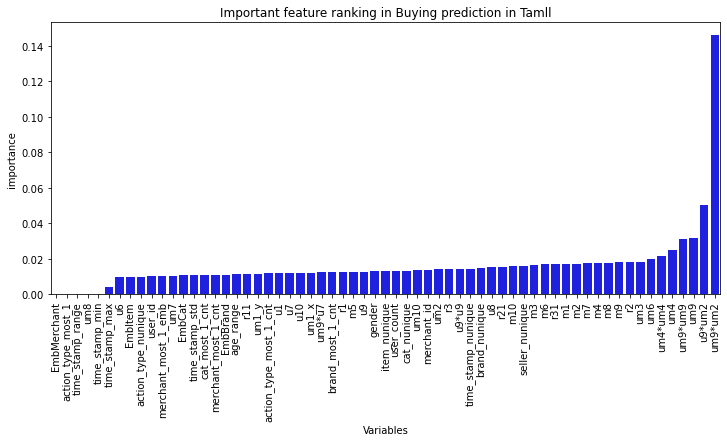

In [ ]:
from xgboost import plot_importance
import seaborn as sns
import matplotlib.pyplot as plt

importance_col = model_xgb.feature_importances_.argsort()
feat_importance_xgb = pd.DataFrame({'Variables': train_X.columns[importance_col],
                               'importance':model_xgb.feature_importances_[importance_col]})  #所有特征归一化到0-100便可以看出重要性
plt.figure(figsize=(12,5))
# sns.catplot(x='Variables', y='importance', data=feat_importance_fraud, height=5,aspect=2,kind='bar')
sns.barplot(x='Variables', y='importance', data=feat_importance_xgb, color='b')

plt.title('Important feature ranking in Buying prediction in Tamll')
plt.xticks(rotation=90)
plt.show()

In [ ]:
prob = model_xgb.predict_proba(test_data)
# prob#[:,1]
submission['prob'] = pd.Series(prob[:,1])
submission.drop(['origin'],axis=1, inplace=True)
submission.to_csv('predication_xgboost.csv',index=False)

In [ ]:
train_x.columns

Index(['user_id', 'merchant_id', 'age_range', 'gender', 'u1', 'u6', 'u7', 'u8',
       'u9', 'u10', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9',
       'm10', 'um1_x', 'um1_y', 'um2', 'um3', 'um4', 'um6', 'um7', 'um8',
       'um9', 'um10', 'r1', 'r2', 'r3', 'r11', 'r21', 'r31', 'user_count',
       'seller_nunique', 'cat_nunique', 'item_nunique', 'brand_nunique',
       'time_stamp_nunique', 'action_type_nunique', 'time_stamp_max',
       'time_stamp_min', 'time_stamp_std', 'time_stamp_range',
       'merchant_most_1', 'cat_most_1', 'brand_most_1', 'action_type_most_1',
       'merchant_most_1_cnt', 'cat_most_1_cnt', 'brand_most_1_cnt',
       'action_type_most_1_cnt', 'EmbMerchant', 'EmbBrand', 'EmbCat',
       'EmbItem', 'u9*um2', 'um9*um2', 'u9*u9', 'um9*u7', 'um9*um9',
       'um4*um4'],
      dtype='object')

In [ ]:
### shap
import shap

shap_interaction_values = shap.TreeExplainer(model).shap_interaction_values(train_X)
shap.summary_plot(shap_interaction_values, train_X, max_display=10)